# Подключаем пакеты и выбираем папку

In [12]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import seaborn as sns
import os
import time
import gc

from time import time

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from ipywidgets import IntProgress
from IPython.display import display

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

In [13]:
# Указываем путь к директории
#directory = "C:\Synology\Alex\dev\\trackCalc\\antibiotic"
#directory = "C:\Synology\Alex\dev\\trackCalc\\test\\file_test"
#directory = "D:\\P.a 1840-1 мг-мл 4Ч"
directory = "D:\\POBEDA\\Для Алексея 10.04.25"


filt_len = 2 #длина траекторий для фильтрации, 50 - это 4 секунды хотя бы
base_n = 50 #база для усрднения фона
threshold_bc = 2 #уровень шума для вычитания фона

k_to_µm = 0.16

#_______________________________

files = []
trj_list = []
hist_list = []
title_list = []
label_list = []
 
# Выводим список файлов
files += os.listdir(directory)
i = 0
for name in files:
    if name.split('.')[-1] == 'avi':
        title_list.append(name)
        print(i, name)
        i+=1
label_list = title_list

#выбираем файл и загружаем его
print('первый файл в папке')
file_name = title_list[0]

frames = gray(pims.Video(directory + '\\' + file_name))
title = file_name
print(file_name, len(frames))
frames[10]

gc.collect()

0 К-1840-1час.avi
1 К-1840-2 часа.avi
2 ФТ-1840-1 час.avi
3 ФТ-1840-2часа.avi
первый файл в папке
К-1840-1час.avi 863


44

# Проверка параметров на первом кадре

calculate background
63.8450129032135 sec
delete background (dark feathcers)
159.99947810173035 sec


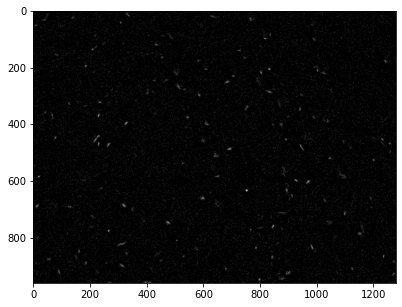

In [14]:
def calculate_background(frames):
    
    print('calculate background')
    t1 = time()

    _b = np.cumsum(frames, 0)
    _b = (_b[base_n:] - _b[:-base_n]) / base_n
    before = base_n // 2
    after = base_n - before
    _b = np.pad(_b, [[before, after], [0, 0], [0, 0]], mode='edge')

    t2 = time()
    print(t2 - t1,"sec")
    gc.collect()

    print('delete background (dark feathcers)')
    t1 = time()

    _a = _b - np.asarray(frames)
    res = np.where(_a < threshold_bc, 0, _a)

    t2 = time()
    t2 - t1
    print(t2 - t1,"sec")
    gc.collect()
    return res

res = calculate_background(frames)

fig, ax = plt.subplots()
ax.imshow(res[100])
plt.show()

In [15]:
# Еще раз скопировать наверх после подбора!!!!!!!
inv = False
th = 0
mem = 0

mass_level = 100
max_dist = 40
diam = 21



len: 863


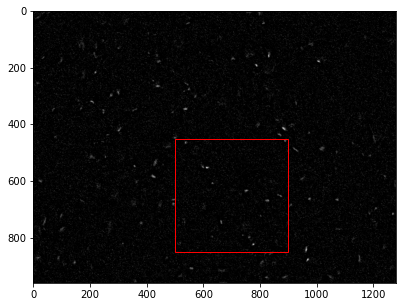

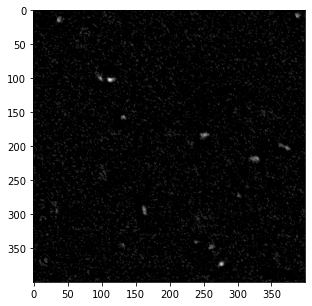

Before: 113
After: 38


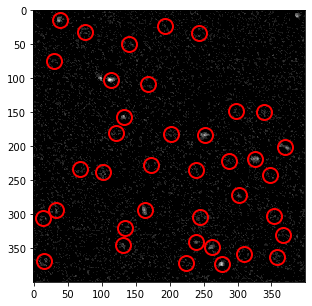

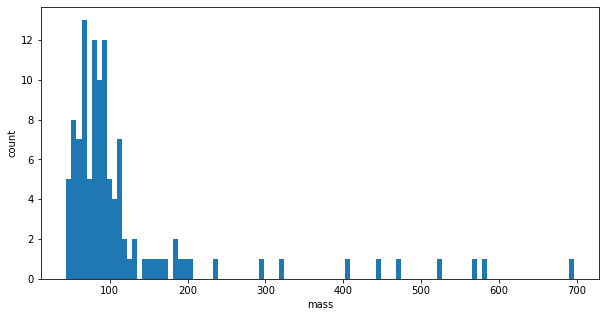

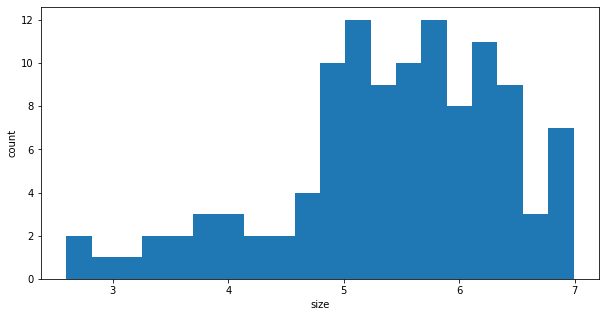

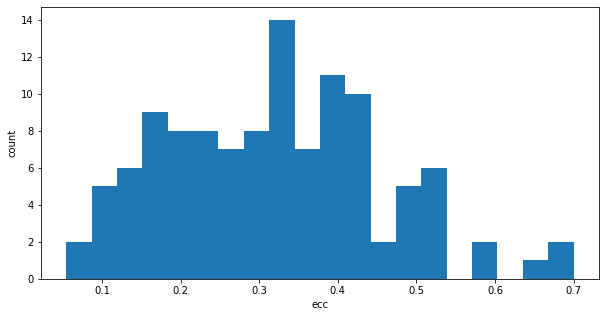

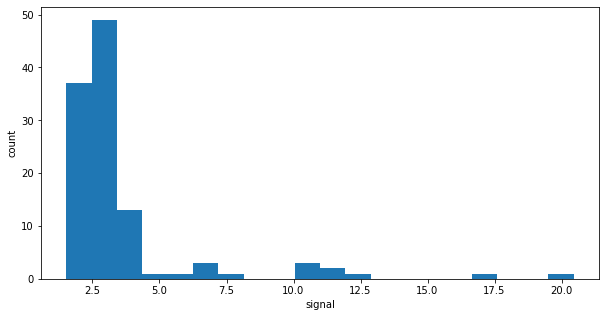

In [16]:
i = 203

x = 500
y = 450
dx = 400
dy = 400

#res[i] = bc_list[i] - frames[i]
#res[i][bc_list[i] - frames[i] < 2] = 0
#res[i][705][550] = 40


one_frame = res[i]
#one_frame = frames[i]
#one_frame = bc_list[i]



fig, ax = plt.subplots()
ax.imshow(one_frame)
rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

print('len:', len(frames))
plt.show()

one_frame = one_frame[y:y+dy,x:x+dx]
fig, ax = plt.subplots()
ax.imshow(one_frame)
plt.show()

#one_frame = res[i]
#one_frame = frames[i]

f = tp.locate(one_frame, diameter = diam, threshold = th, invert=inv)
new_f = f[f['mass'] > mass_level] # чем ярче, тем больше этот параметр. Нам подходят БОЛЬШЕ какого то значения
#new_f = f[f['signal'] > 10] # чем ярче, тем больше этот параметр. Нам подходят БОЛЬШЕ какого то значения
#new_f = f[f['size'] > 4]
#new_f = f[f['ecc'] > 0.7]

print('Before: {0}'.format(len(f)))
print('After: {0}'.format(len(new_f)))
tp.annotate(new_f, one_frame)

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100)
ax.set(xlabel='mass', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['size'], bins=20)
ax.set(xlabel='size', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['ecc'], bins=20)
ax.set(xlabel='ecc', ylabel='count');

fig, ax = plt.subplots()
ax.hist(f['signal'], bins=20)
ax.set(xlabel='signal', ylabel='count');

# Сохранение данных по текущему видео и боработка остальных видео в папке

In [17]:
#находим фичи на всех кадрах по подобранным параметрам и сохраняем в файлы
t1 = time()

f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)

directory
file_name = file_name.split('.')[0]
f.to_csv(directory + "//" + file_name + ".csv")
t2 = time()
t2 - t1
print(t2 - t1,"sec")

Frame 862: 893 features
142.25633883476257 sec


In [18]:
for i in range(1, len(title_list)):
    file_name = title_list[i]
    frames = 0
    f = 0
    res = 0
    
    gc.collect()

    frames = gray(pims.Video(directory + '\\' + file_name))
    title = file_name
    print(str(i+1)+"/"+str(len(title_list)), file_name, len(frames))
    res = calculate_background(frames)
    gc.collect()
    
    t1 = time()
    f = tp.batch(res, diameter = diam, threshold = th, invert=inv, processes=1)
    
    file_name = file_name.split('.avi')[0]
    print(file_name)
    f.to_csv(directory + "//" + file_name + ".csv")
    t2 = time()
    t2 - t1
    print(t2 - t1,"sec")
    
print("done!")   

Frame 866: 874 features
ФТ-1840-2часа
151.11124801635742 sec
done!


In [10]:
gc.collect()

53

# Вычисление траекторий

In [ ]:
# Создаем пустые списки с данными по гистограммам
files = []
trj_list = []
hist_list = []
title_list = []
label_list = [] #На тот случай, если мы захотим подписать гистограммы как-то иначе - не так, как названы файлы
 
# Добавляем файлы в список
files += os.listdir(directory)
 
# Выводим список файлов
print(files)
for name in files:
    if name.split('.')[-1] == 'avi':
        title_list.append(name)
label_list = title_list

#обработка и вычисление траекторий у всех файлов (без фильтрции)
text_log = ''
trj_list = []
for i in range(len(title_list)):
    text_log += 'file ' + str(i+1) + '/' +  str(len(title_list))
    print('file ' + str(i+1) + '/' +  str(len(title_list)))
    try:
        trj = create_trj_data(title_list[i])
        trj_list.append(trj)
        text_log += title_list[i] +' done!' + '\n'
        print('done!')
    except:
        text_log += title_list[i] + ' fail!' + '\n'
        print('fail!')
print(text_log)

Frame 867: 9 trajectories present.
done!
file 1/111ч фт.avi done!
file 2/1120ч фт.avi done!
file 3/112ч фт.avi done!
file 4/113ч фт.avi done!
file 5/116ч фт.avi done!
file 6/11к 1ч.avi done!
file 7/11к 20ч.avi done!
file 8/11к 2ч.avi done!
file 9/11к 6ч.avi done!
file 10/11к0ч.avi done!
file 11/11к3ч.avi done!



# *Загрузка траекторий из файла

In [ ]:
# Создаем пустые списки с данными по гистограммам
files = []
trj_list = []
hist_list = []
title_list = []
label_list = [] #На тот случай, если мы захотим подписать гистограммы как-то иначе - не так, как названы файлы
 
# Добавляем файлы в список
directory = 'C:\Synology\Alex\\dev\\trackCalc\\test\\p'
files += os.listdir(directory)
 
# Выводим список файлов
print('введите номер папки с данными (нумерация с нуля)')
for i in range(len(files)):
    print(i, files[i])
folder_name = files[int(input())]

data_directory = directory +'\\' + folder_name
files = []
files += os.listdir(data_directory)
print(data_directory)
print(files)

for name in files:
    if name.split('.')[-1] == 'trj':
        title_list.append(name)
        trj_list.append(pd.read_csv(data_directory + '\\'+ name, index_col=0))
    if name.split('.')[-1] == 'hst':
        hist_list.append(pd.read_csv(data_directory + '\\'+ name, index_col=0))
label_list = title_list

введите номер папки с данными (нумерация с нуля)
0 4 видео для патента.docx
1 p_trj
2 zef
3 ~$видео для патента.docx
4 амп-10мкг на мл-2.avi
5 ген-10мкг на мл-2.avi
6 контроль.avi
7 цеф-10мкг на мл-2.avi
1
C:\Synology\Alex\dev\trackCalc\test\p\p_trj
['log.txt', 'амп-10мкг на мл-2.avi.hst', 'амп-10мкг на мл-2.avi.trj', 'ген-10мкг на мл-2.avi.hst', 'ген-10мкг на мл-2.avi.trj', 'контроль.avi.hst', 'контроль.avi.trj', 'цеф-10мкг на мл-2.avi.hst', 'цеф-10мкг на мл-2.avi.trj']


# Построение гистограмм

In [ ]:
# Создание данных для гисторгамм. Фильтрация и вычитание дрейфа
hist_list = []
for i in range(len(trj_list)):
    t = trj_list[i]

    #считаем средние скорости для гистограммы
    speeds = []
    d = tp.compute_drift(t)
    t = tp.subtract_drift(t.copy(), d)

    #рассчет средней скорости у частиц
    t1 = tp.filter_stubs(t, filt_len)
    print(title_list[i], 'len more then ', filt_len, ' = ', t1['particle'].nunique())
    for i in t1['particle'].unique():
        speed = t1[t1['particle'] == i]
        speed = speed.diff()
        speed['v'] = (speed['x']*speed['x'] + speed['y']*speed['y'])**(0.5)/speed['frame']
        v = speed['v'].mean()
        speeds.append(v)

    hist_list.append(pd.DataFrame({'number': t1['particle'].unique(), 'mean_V': speeds}))

1ч фт.avi len more then  30  =  2
20ч фт.avi len more then  30  =  22
2ч фт.avi len more then  30  =  1
3ч фт.avi len more then  30  =  3
6ч фт.avi len more then  30  =  24
к 1ч.avi len more then  30  =  2
к 20ч.avi len more then  30  =  4
к 2ч.avi len more then  30  =  1
к 6ч.avi len more then  30  =  22
к0ч.avi len more then  30  =  0
к3ч.avi len more then  30  =  2


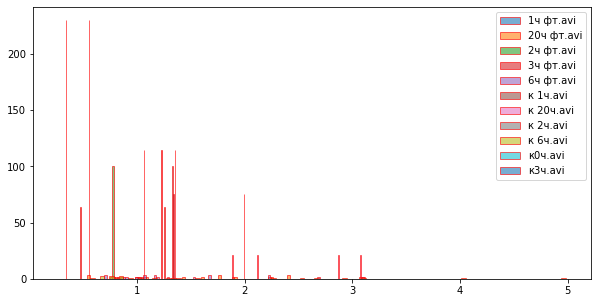

In [ ]:
# Построение гистограмм

for i in range(len(hist_list)):
    # plotting
    plt.hist(hist_list[i]['mean_V'], bins=100, label=label_list[i], alpha=0.6, edgecolor='red', density = True)

plt.legend()

# Showing the plot using plt.show()
plt.show()

# *Сохранение траекторий и гистограмм в файл

In [ ]:
print('введите название для папки с рассчетом траекторий')
sucsess = False
while not sucsess:
    # Создаем директорию
    sucsess = True
    try:
        title_calc = input()
        os.makedirs(directory + '\\' + title_calc)
    except FileExistsError:
        print('Директория уже существует')
        sucsess = False

# Создаем файл и записываем в него параметры и лог
with open(directory + '\\' + title_calc + '\log.txt', 'w', encoding='utf-8') as f:
    f.write('inv '+ str(inv) + '\n')
    f.write('th ' + str(th) + '\n')
    f.write('mass_level '+ str(mass_level) + '\n')
    f.write('mem ' + str(mem) + '\n')
    f.write('max_dist ' + str(max_dist) + '\n')
    f.write('diam ' + str(diam) + '\n')
    f.write('filt_len ' + str(filt_len) + '\n')
    f.write('base_n ' + str(base_n) + '\n')
    f.write('threshold_bc ' + str(threshold_bc) + '\n')
    f.write('inv' + str(inv) + '\n' + '\n')
    f.write(text_log)

for i in range(len(trj_list)):
    trj_list[i].to_csv(directory + '\\' + title_calc + '\\' + title_list[i] + '.trj')
    hist_list[i].to_csv(directory + '\\' + title_calc + '\\' + title_list[i] + '.hst')

введите название для папки с рассчетом траекторий


 d15mass300


# Сравнение гистограмм распределения среднего смещения за кадр

1 / 11
2 / 11
3 / 11
4 / 11
5 / 11
6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11


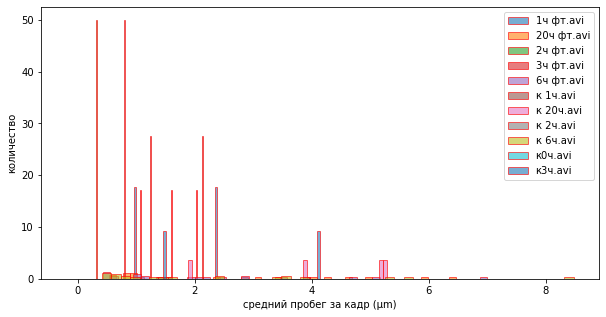

In [ ]:
filt_len = 30

hist_list = []
for i in range(len(trj_list)):
    t = trj_list[i]
    t1 = tp.filter_stubs(t, filt_len)
    d = []
    for j in t1['particle'].unique():
        prtc = t1[t1['particle'] == j]
        #ниже формула рассчета диагонали прямоугодьника, в который вписанна траектория. Я почти уверен в ней
        l = (( (min(prtc['x']) - max(prtc['x']))**2 +  (min(prtc['y']) - max(prtc['y']))**2  )**0.5)*k_to_µm
        #d.append(l/len(prtc))
        d.append(l)
    
    hist_list.append(pd.DataFrame({'number': t1['particle'].unique(), 'mean_V': d}))
    plt.hist(d, bins=50, label=title_list[i], alpha=0.6, edgecolor='red', density = True)
    print(i+1, '/', len(trj_list))
    

plt.ylabel('количество')
plt.xlabel('средний пробег за кадр (µm)')
plt.legend()

plt.show()

# Сравниваем 2 гистограммы друг с другом (это надо править - что именно сравниваем, как и тд)

гистограммы в памяти
0 1ч фт.avi
1 20ч фт.avi
2 2ч фт.avi
3 3ч фт.avi
4 6ч фт.avi
5 к 1ч.avi
6 к 20ч.avi
7 к 2ч.avi
8 к 6ч.avi
9 к0ч.avi
10 к3ч.avi
введите номера ДВУХ интересующих гистограмм через пробел


 4 8


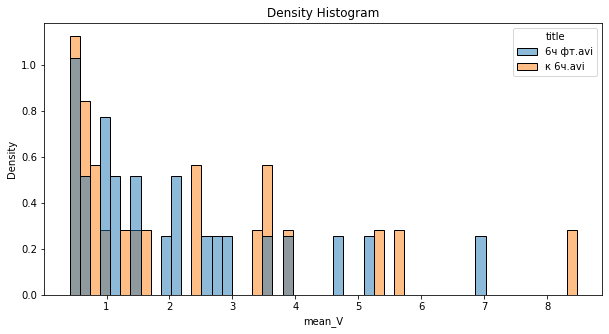

In [ ]:
print('гистограммы в памяти')
for i in range(len(hist_list)):
    print(i, title_list[i])

print('введите номера ДВУХ интересующих гистограмм через пробел')
ind = [int(i) for i in input().split()]

res = []
for i in ind:
    temp = hist_list[i]
    temp['title'] = title_list[i]
    res.append(temp)
df_comp = pd.concat(res)
df_comp.reset_index(inplace=True)

#нормированная гистограмма
sns.histplot(data=df_comp, x='mean_V', hue='title', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

0.2597331508723914


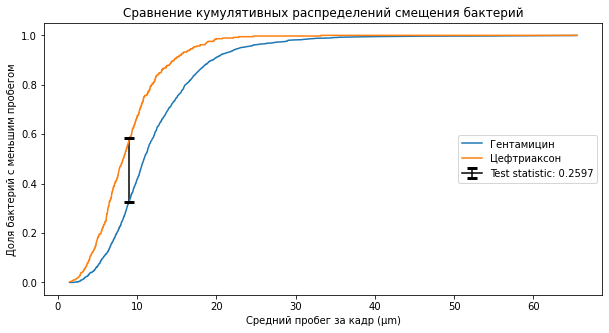

In [ ]:
'''
Идея критерия Колмогорова — Смирнова — сравнить кумулятивные распределения двух групп.
В частности, статистика теста Колмогорова — Смирнова представляет собой максимальную абсолютную разницу
между двумя кумулятивными распределениями.
'''

income_t = df_comp.loc[df_comp.title==title_list[ind[0]], 'mean_V'].values
income_c = df_comp.loc[df_comp.title==title_list[ind[1]], 'mean_V'].values

df_ks = pd.DataFrame()
df_ks['mean_V'] = np.sort(df_comp['mean_V'].unique())
df_ks[title_list[ind[0]]] = df_ks['mean_V'].apply(lambda x: np.mean(income_c<=x))
df_ks[title_list[ind[1]]] = df_ks['mean_V'].apply(lambda x: np.mean(income_t<=x))

k = np.argmax( np.abs(df_ks[title_list[ind[0]]] - df_ks[title_list[ind[1]]]))
ks_stat = np.abs(df_ks[title_list[ind[0]]][k] - df_ks[title_list[ind[1]]][k])


y = (df_ks[title_list[ind[0]]][k] + df_ks[title_list[ind[1]]][k])/2
plt.plot('mean_V', title_list[ind[0]], data=df_ks, label=title_list[ind[0]])
plt.plot('mean_V', title_list[ind[1]], data=df_ks, label=title_list[ind[1]])
plt.errorbar(x=df_ks['mean_V'][k], y=y, yerr=ks_stat/2, color='k',
      capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
plt.legend(loc='center right');
plt.title("Сравнение кумулятивных распределений смещения бактерий");
plt.ylabel('Доля бактерий с меньшим пробегом')
plt.xlabel('Средний пробег за кадр (µm)')
print(ks_stat)



In [ ]:
title_list


['Ампициллин', 'Гентамицин', 'Контроль', 'Цефтриаксон']

In [ ]:
title_list = ['Ампициллин', 'Гентамицин', 'Контроль', 'Цефтриаксон']

In [ ]:
Out[15]

['амп-10мкг на мл-2.avi.trj',
 'ген-10мкг на мл-2.avi.trj',
 'контроль.avi.trj',
 'цеф-10мкг на мл-2.avi.trj']

In [ ]:



for i in range(len(trj_list)):
    t = trj_list[i]
    n = 0
    for j in t['frame'].unique():
        n += len(t[t['frame'] == j]['particle'].unique())

    n = n/len(t['frame'].unique())
    print(label_list[i], n)

амп-10мкг на мл-2.avi.trj 69.92814371257485
ген-10мкг на мл-2.avi.trj 80.0590318772137
контроль.avi.trj 84.09360730593608
цеф-10мкг на мл-2.avi.trj 303.1716247139588


# Старые способы сравнения (для истории)

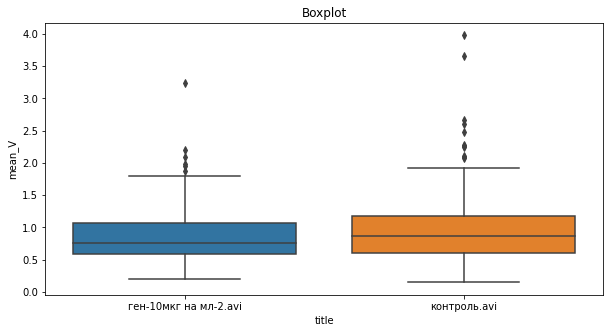

In [ ]:
# ящик с усами
sns.boxplot(data=df_comp, x='title', y='mean_V');
plt.title("Boxplot");

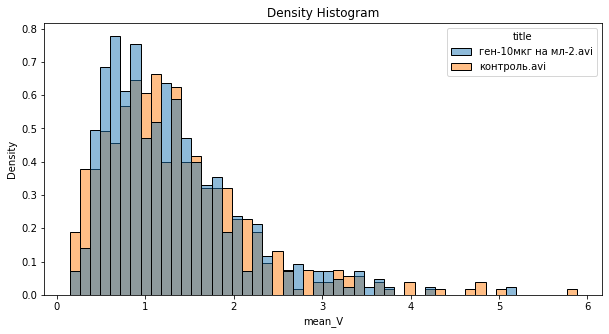

In [ ]:
#нормированная гистограмма
sns.histplot(data=df_comp, x='mean_V', hue='title', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

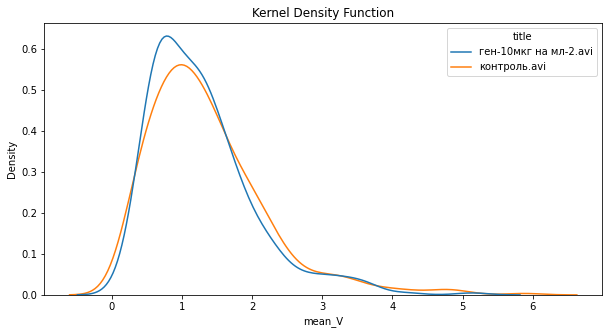

In [ ]:
# метод ядерной оценки плотности. Уходим от проблемы выбора количества бинов
sns.kdeplot(data=df_comp, x='mean_V', hue='title', common_norm=False);
plt.title("Kernel Density Function");

In [ ]:
#среднее, медиана, среднеквадратичные отклонения

for i in ind:
    print("{:20} (среднее: {:.3f}, ср.кв.отк.: {:.3f}, медиана: {:.3f})".format(title_list[i], hist_list[i]['mean_V'].mean(),
                                                                         hist_list[i]['mean_V'].std(),
                                                                         hist_list[i]['mean_V'].median ()))


In [ ]:
#  кумулятивная функция распределения. В каждой точке оси x (скорость частицы) наносится процент количества бактерий,
# имеющих равное или меньшее значение. Например значение 0,5 - это медианна

sns.histplot(data=df_comp, x='mean_V', hue='title', bins=len(df_comp), stat="density",
      element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

In [ ]:
'''
Идея критерия Колмогорова — Смирнова — сравнить кумулятивные распределения двух групп.
В частности, статистика теста Колмогорова — Смирнова представляет собой максимальную абсолютную разницу
между двумя кумулятивными распределениями.
'''

income_t = df_comp.loc[df_comp.title==title_list[ind[0]], 'mean_V'].values
income_c = df_comp.loc[df_comp.title==title_list[ind[1]], 'mean_V'].values

df_ks = pd.DataFrame()
df_ks['mean_V'] = np.sort(df_comp['mean_V'].unique())
df_ks[title_list[ind[0]]] = df_ks['mean_V'].apply(lambda x: np.mean(income_c<=x))
df_ks[title_list[ind[1]]] = df_ks['mean_V'].apply(lambda x: np.mean(income_t<=x))

k = np.argmax( np.abs(df_ks[title_list[ind[0]]] - df_ks[title_list[ind[1]]]))
ks_stat = np.abs(df_ks[title_list[ind[0]]][k] - df_ks[title_list[ind[1]]][k])


y = (df_ks[title_list[ind[0]]][k] + df_ks[title_list[ind[1]]][k])/2
plt.plot('mean_V', title_list[ind[0]], data=df_ks, label=title_list[ind[0]])
plt.plot('mean_V', title_list[ind[1]], data=df_ks, label=title_list[ind[1]])
plt.errorbar(x=df_ks['mean_V'][k], y=y, yerr=ks_stat/2, color='k',
      capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
plt.legend(loc='center right');
plt.title("Kolmogorov-Smirnov Test");
print(ks_stat)

сделать нормальную размерность!!! ( на этапе построения графиков - чтбоы можно было сделать потом со старыми данными)
почитать про продвинутую линковку
Сделать сохранени и загрузку в файле

